<a href="https://colab.research.google.com/github/Francesco-Tagliabue/DL-challenges/blob/main/c2/src/shrek_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ⚙️ **Libraries Import**

In [26]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

# Configurazione di TensorBoard e directory
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.9.0+cpu
Device: cpu


In [27]:
os.environ['KAGGLE_USERNAME'] = "giorgiamanioudaki"
os.environ['KAGGLE_KEY'] = "1d894bf85af1afc62f1c89427d9cbf79"
!kaggle competitions download -c an2dl2526c2v2


an2dl2526c2v2.zip: Skipping, found more recently modified local copy (use --force to force download)


In [28]:
import zipfile

with zipfile.ZipFile("an2dl2526c2v2.zip", "r") as zip_ref:
    zip_ref.extractall("data")

In [29]:
import cv2
def load_images_from_folder(folder):
    """
    Load and preprocess images from a specified folder.

    Args:
        folder (str): Path to the folder containing images

    Returns:
        np.ndarray: Array of preprocessed images with shape (N, H, W, C)
    """
    images = []

    # Iterate through files in the specified folder
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))

        # Normalize image pixel values to a float range [0, 1]
        img = (img / 255).astype(np.float32)

        # Convert image from BGR to RGB
        img = img[...,::-1]

        # Make the image dataset squared
        dim = min(img.shape[:-1])
        img = img[(img.shape[0]-dim)//2:(img.shape[0]+dim)//2,
                  (img.shape[1]-dim)//2:(img.shape[1]+dim)//2, :]

        # Resize the image to 224x224 pixels
        img = cv2.resize(img, (224, 224))

        if img is not None:
            images.append(img)

    return np.array(images)

# Load images from the data folder
path = 'data/train_data'
train_data = load_images_from_folder(path)

# Load images from the 'items/' folder
path = 'data/test_data'
test_data = load_images_from_folder(path)

print(f"Loaded {len(train_data)} train data")
print(f"Loaded {len(test_data)} test data")

Loaded 1382 train data
Loaded 954 test data


In [30]:
labels = pd.read_csv('data/train_labels.csv')
labels.head(10)


sample_index            label
0  img_0000.png  Triple negative
1  img_0001.png        Luminal B
2  img_0002.png        Luminal B
3  img_0003.png        Luminal B
4  img_0004.png        Luminal B
5  img_0005.png          HER2(+)
6  img_0006.png        Luminal A
7  img_0007.png        Luminal B
8  img_0008.png          HER2(+)
9  img_0009.png        Luminal B

In [31]:
!pip install imagehash

In [32]:
from PIL import Image, ImageOps
import imagehash # pip install imagehash

def canonical_hash(path, hash_size=16):
    """
    Rotation + flip invariant hash.
    Returns a *string* (hex) representing the canonical hash.
    """
    img = Image.open(path).convert("RGB")

    hash_strs = []

    for k in range(4):
        r = img.rotate(90 * k, expand=True)

        # original at this rotation
        h1 = imagehash.phash(r, hash_size=hash_size)
        hash_strs.append(str(h1))

        # mirrored at this rotation
        r_flip = ImageOps.mirror(r)
        h2 = imagehash.phash(r_flip, hash_size=hash_size)
        hash_strs.append(str(h2))

    # canonical: lexicographically smallest hash string
    return min(hash_strs)


In [33]:
TRAIN_DIR = "data/train_data"
from collections import defaultdict

hash_to_files = defaultdict(list)

for fname in os.listdir(TRAIN_DIR):
    if not fname.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".tiff")):
        continue

    fpath = os.path.join(TRAIN_DIR, fname)
    try:
        h = canonical_hash(fpath)       # now h is already a string
        hash_to_files[h].append(fname)  # no need for str(h) here
    except Exception as e:
        print(f"Error on {fname}: {e}")


In [34]:
duplicates_rotinv = [
    tuple(files)
    for files in hash_to_files.values()
    if len(files) > 1
]

len(duplicates_rotinv), duplicates_rotinv[:10]


(60,
 [('mask_0005.png', 'mask_0037.png'),
  ('mask_0123.png', 'mask_0521.png'),
  ('mask_0058.png', 'mask_0565.png'),
  ('mask_0022.png', 'mask_0414.png'),
  ('mask_0095.png', 'mask_0278.png'),
  ('mask_0437.png', 'mask_0499.png'),
  ('mask_0540.png', 'mask_0060.png'),
  ('mask_0551.png', 'mask_0179.png'),
  ('mask_0427.png', 'mask_0196.png'),
  ('mask_0040.png', 'mask_0193.png')])

In [35]:
duplicates_img = [
    tuple(fname.replace("mask_", "img_") for fname in group)
    for group in duplicates_rotinv
]


In [36]:
from PIL import Image
import matplotlib.pyplot as plt

TRAIN_DIR = "data/train_data"

def show_duplicates(groups, max_groups=None):
    """
    Visualize all images in each duplicate group.
    """
    if max_groups is not None:
        groups = groups[:max_groups]

    for group in groups:
        plt.figure(figsize=(4 * len(group), 4))

        for i, fname in enumerate(group, start=1):
            fpath = os.path.join(TRAIN_DIR, fname)

            try:
                img = Image.open(fpath).convert("RGB")
            except Exception as e:
                print(f"Error loading {fname}: {e}")
                continue

            plt.subplot(1, len(group), i)
            plt.imshow(img)
            plt.title(fname, fontsize=8)
            plt.axis("off")

        plt.tight_layout()
        plt.show()


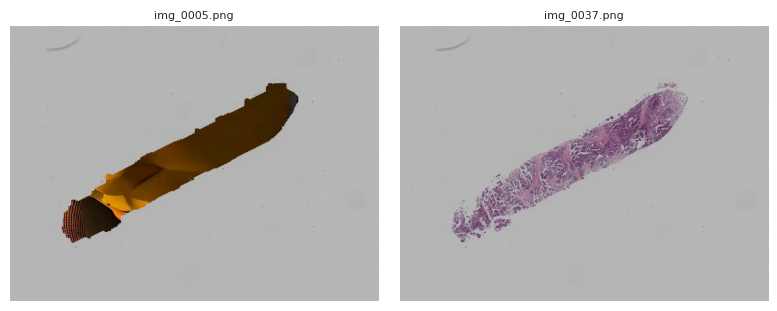

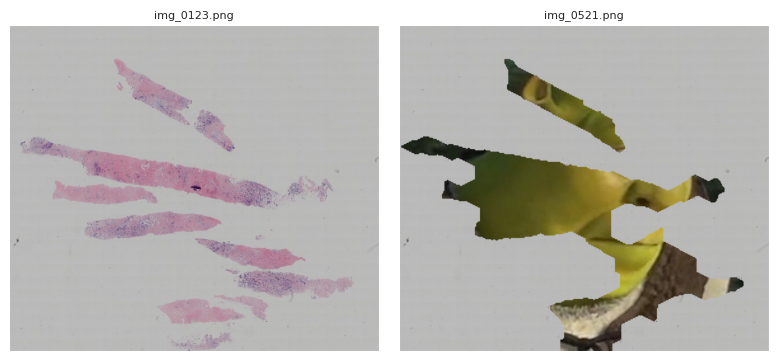

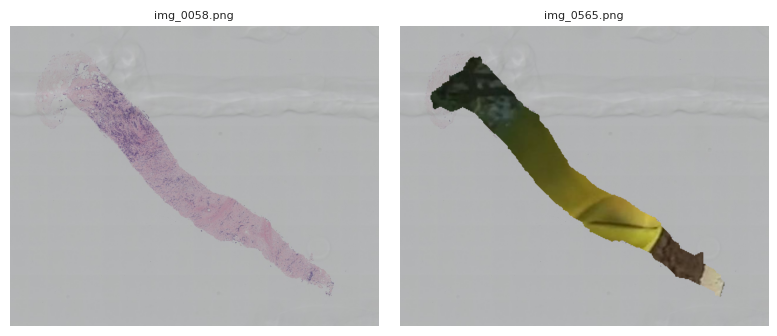

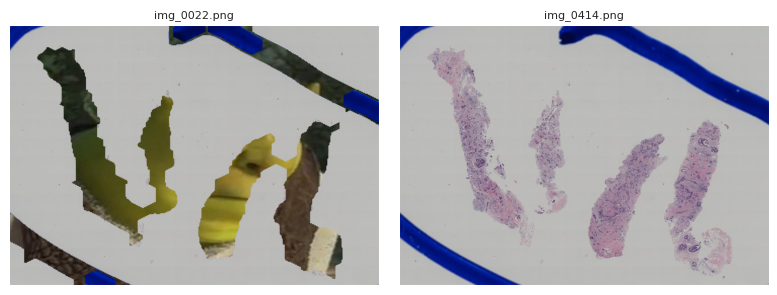

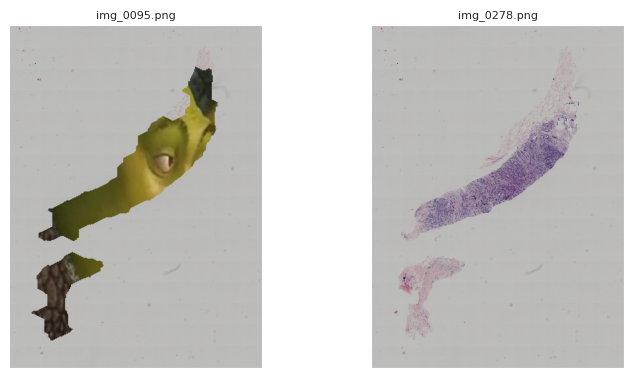

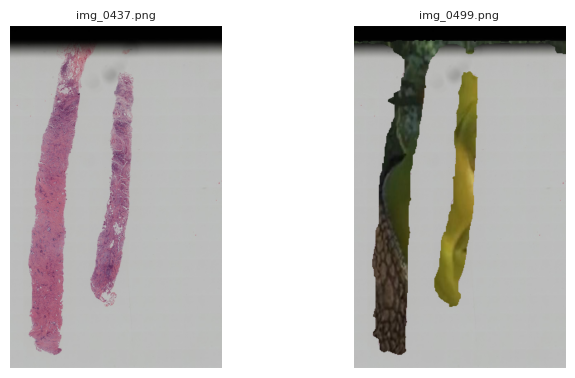

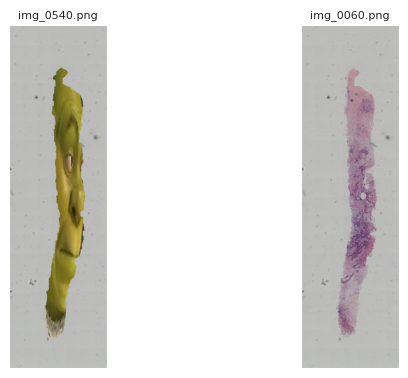

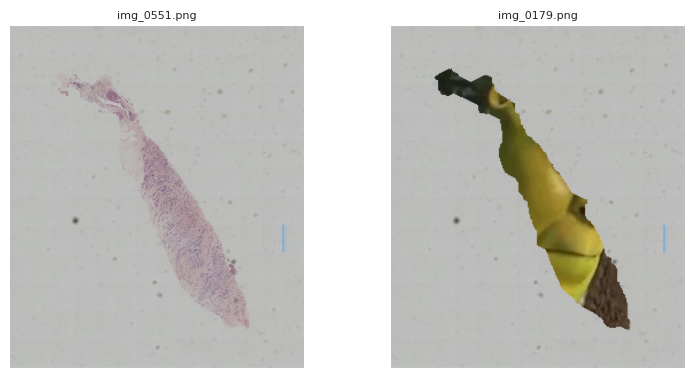

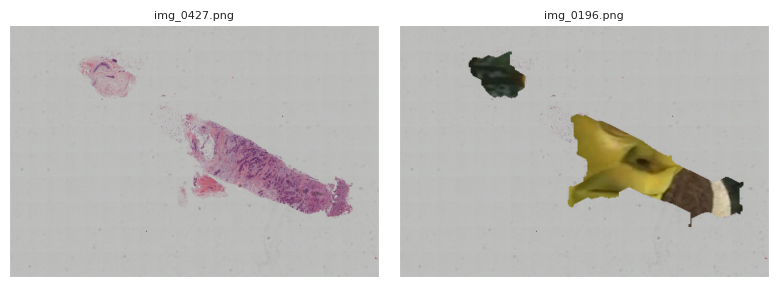

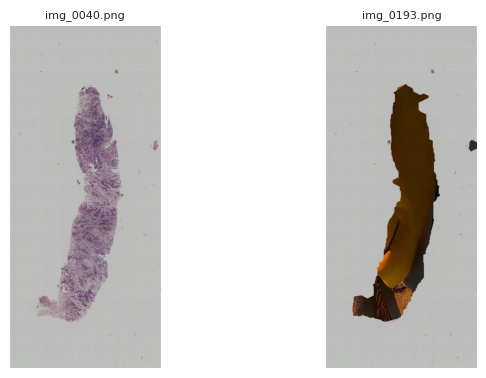

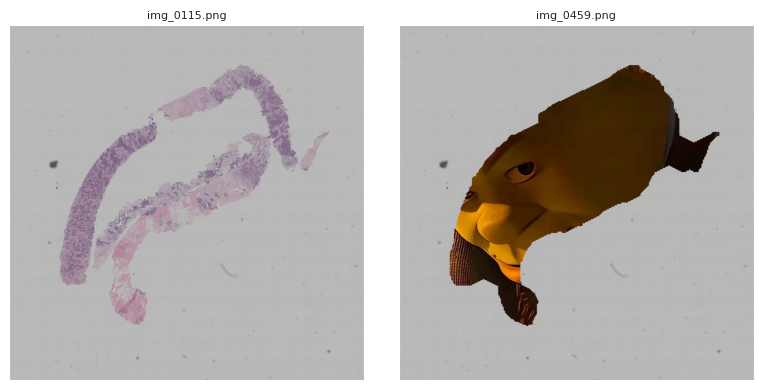

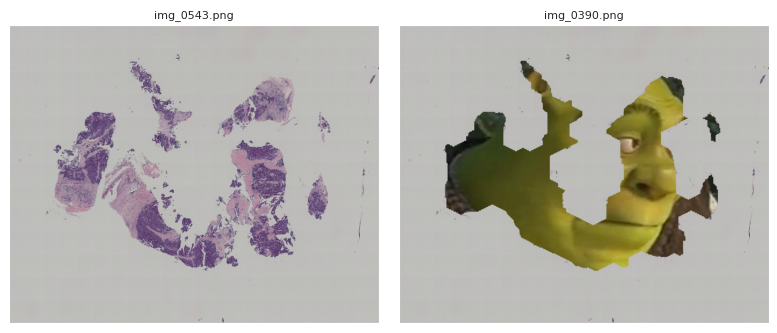

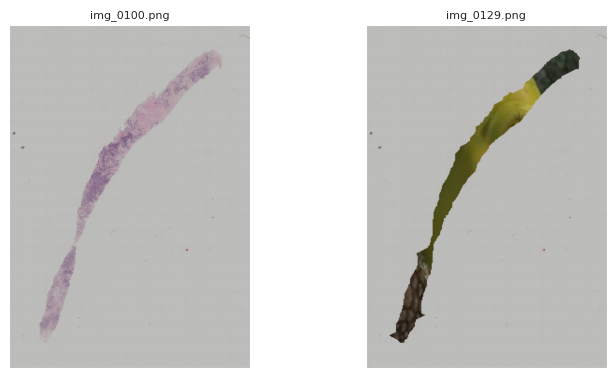

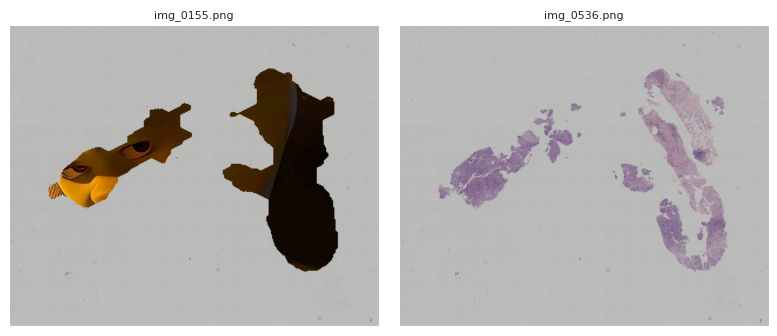

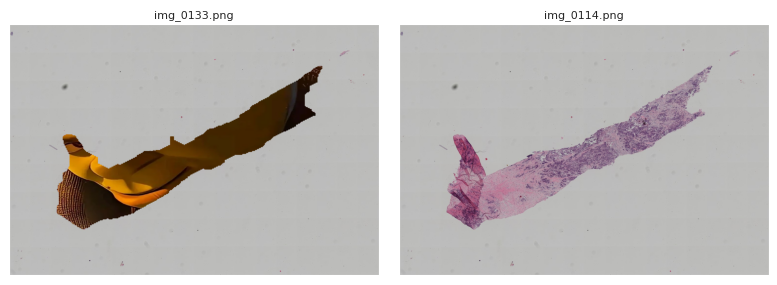

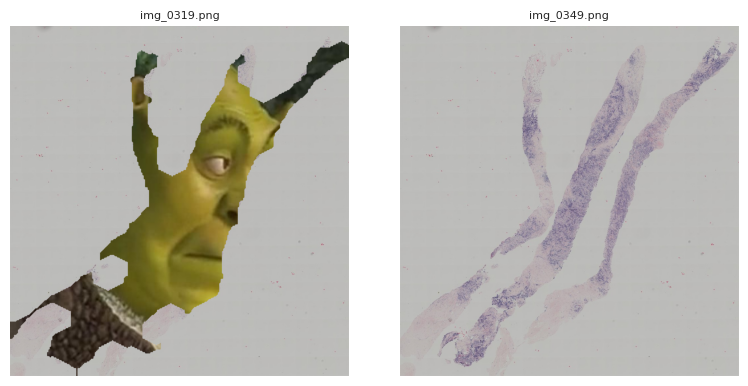

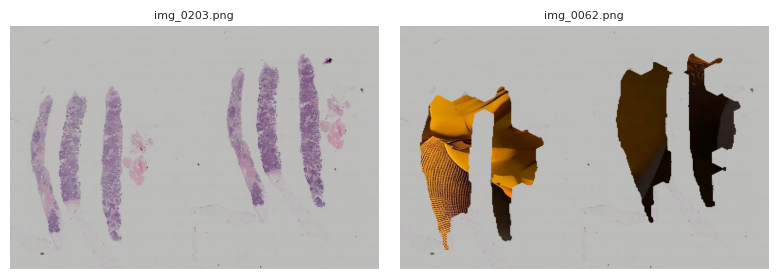

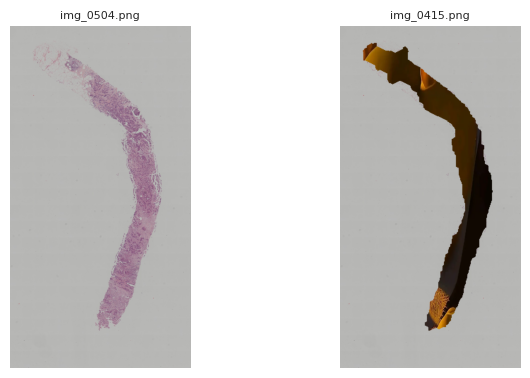

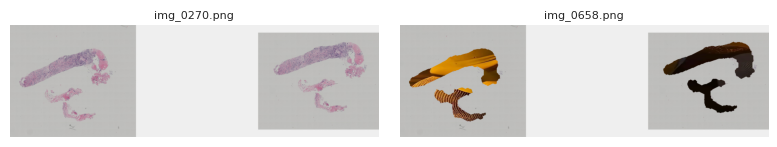

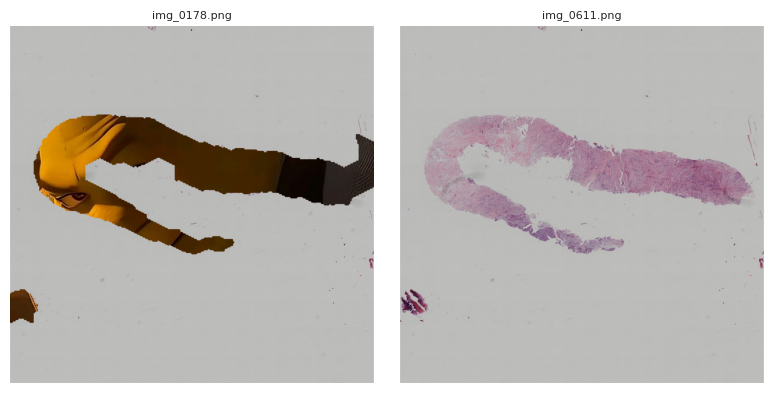

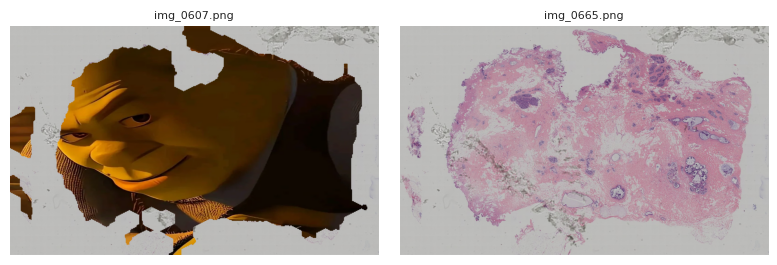

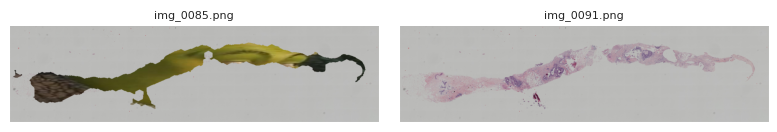

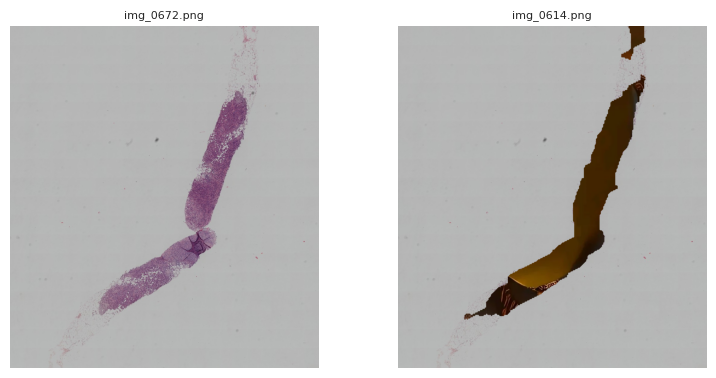

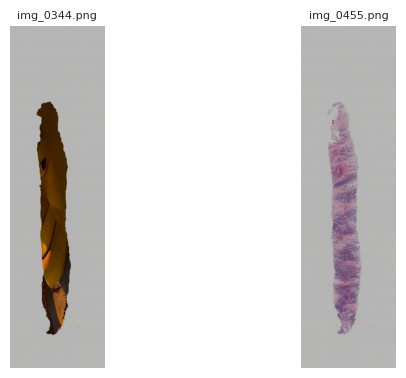

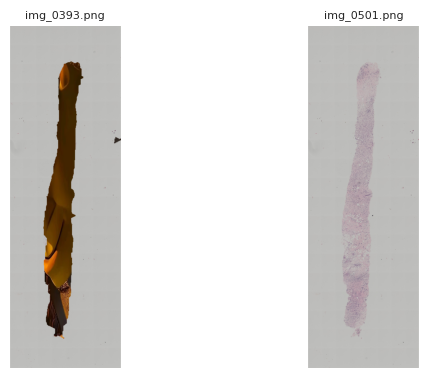

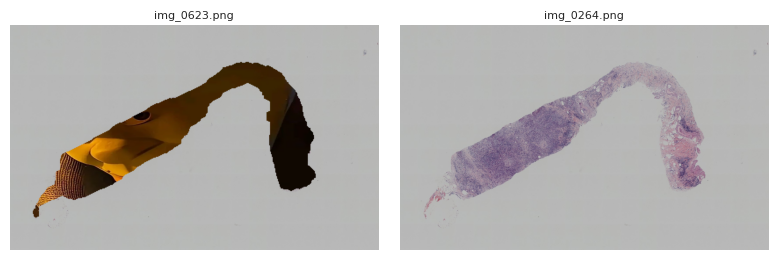

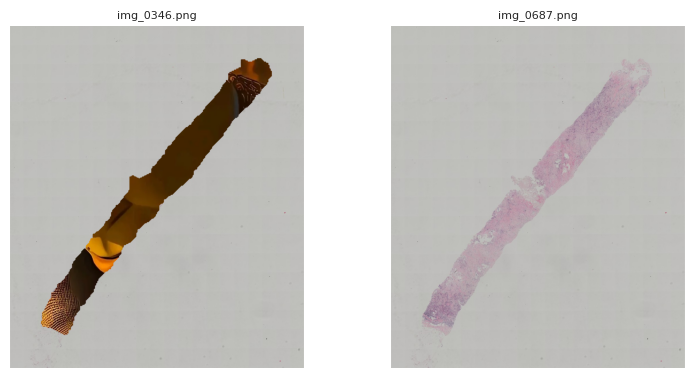

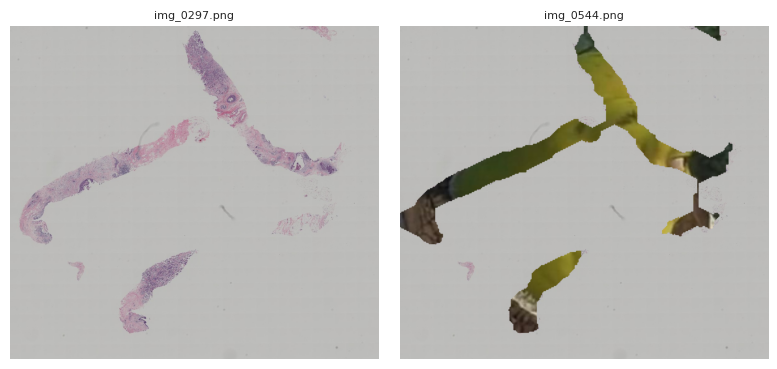

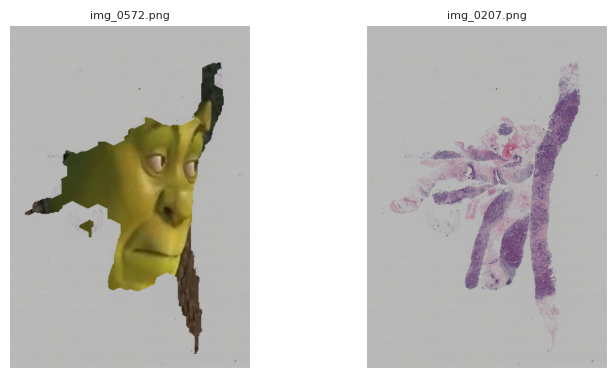

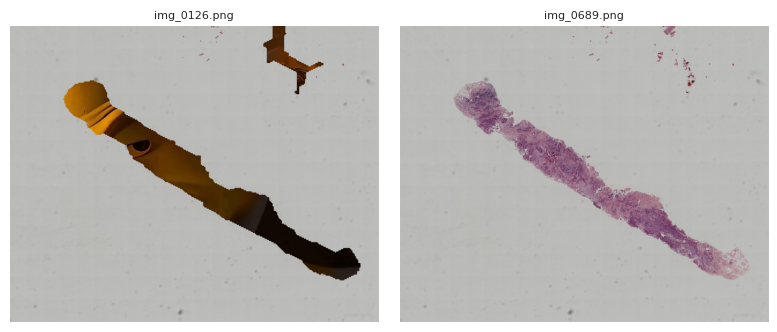

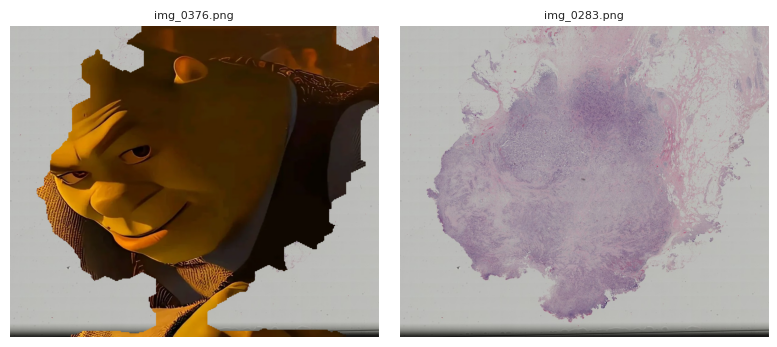

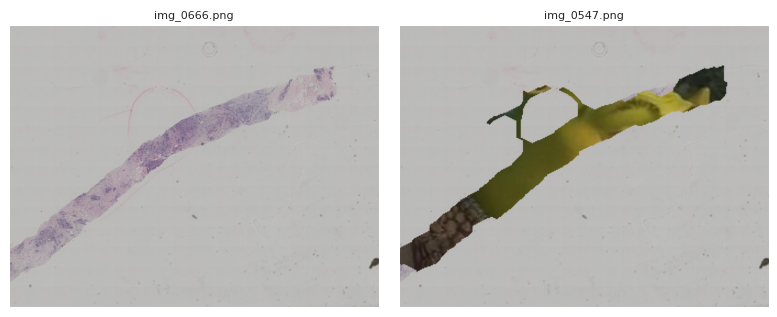

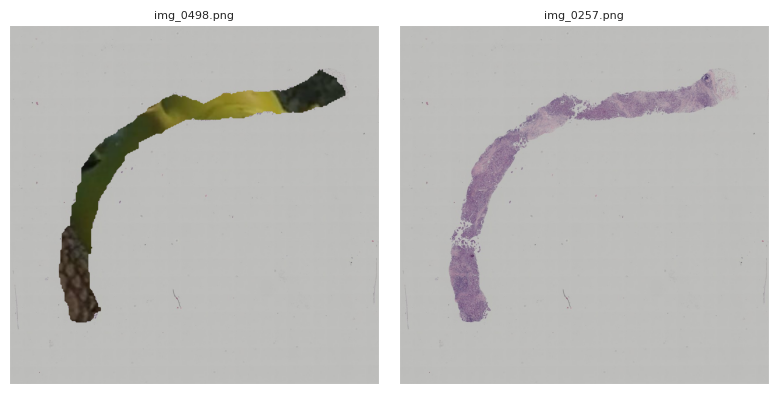

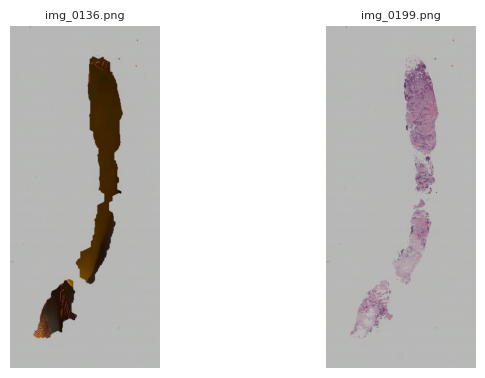

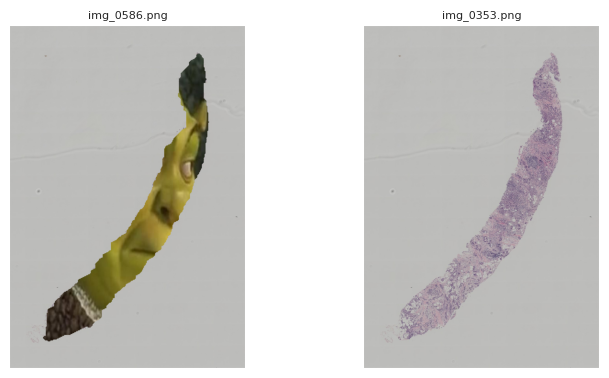

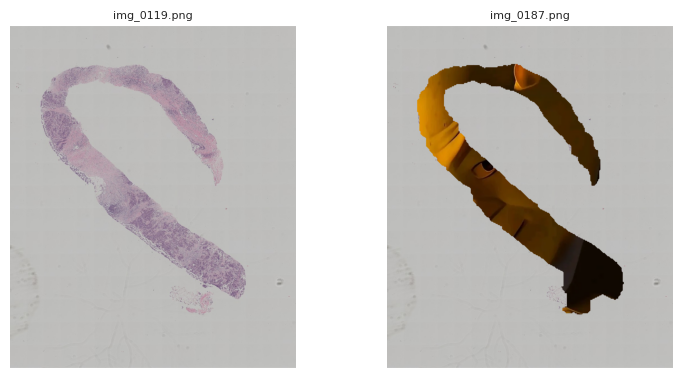

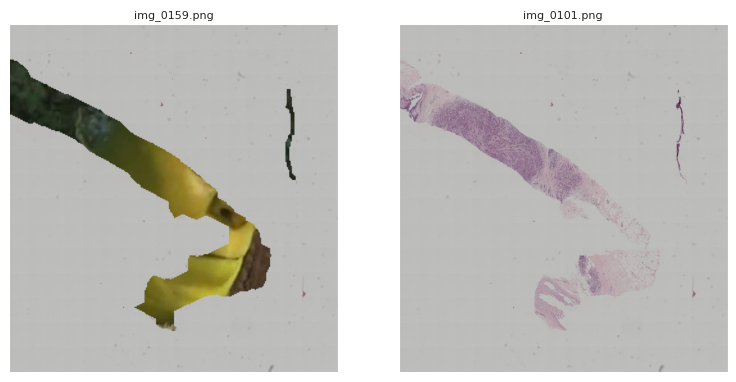

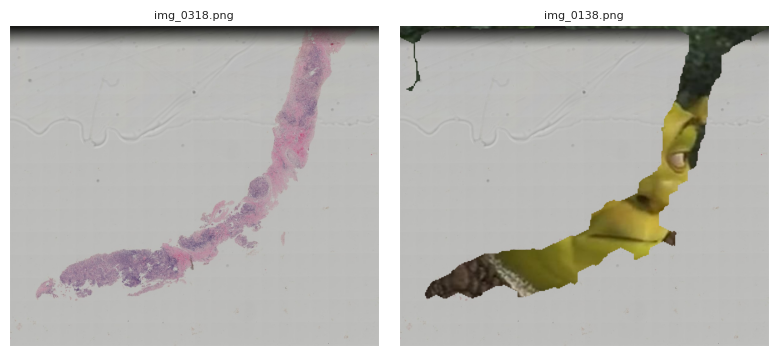

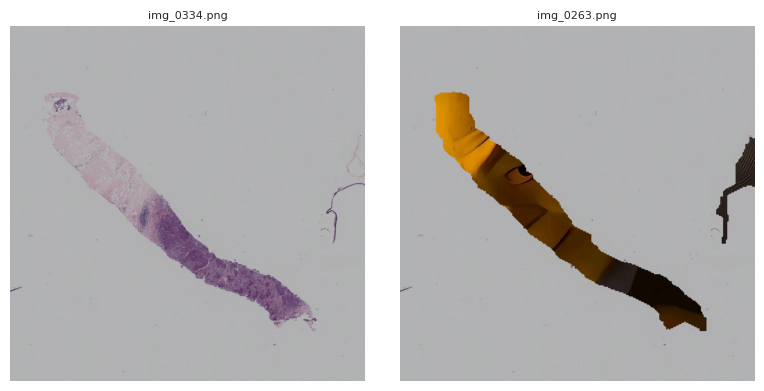

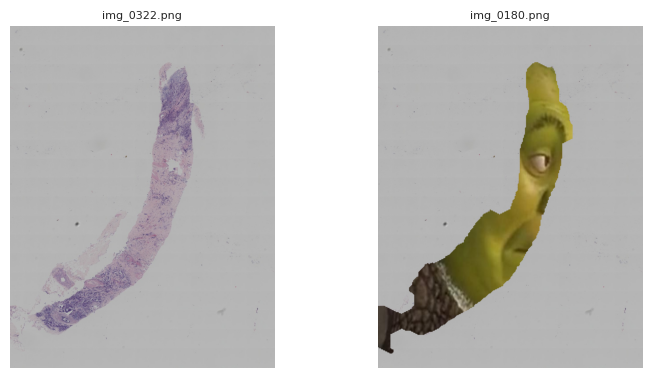

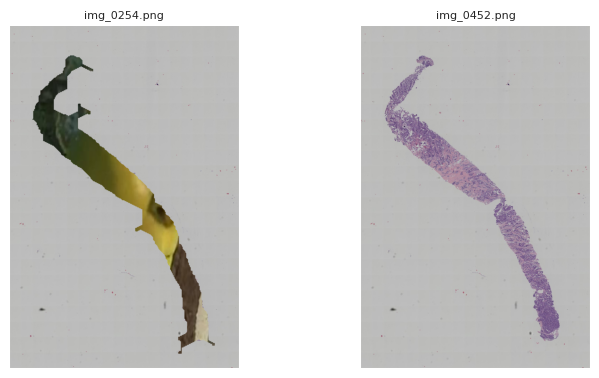

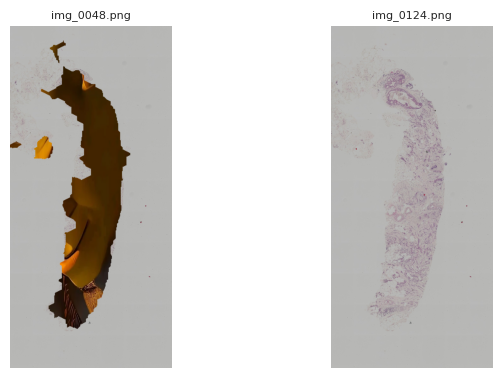

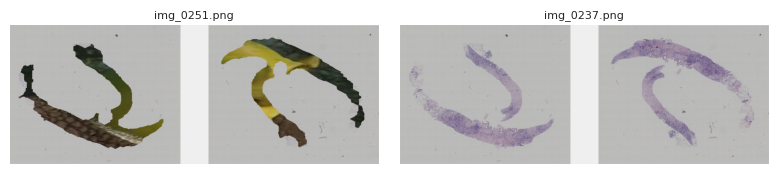

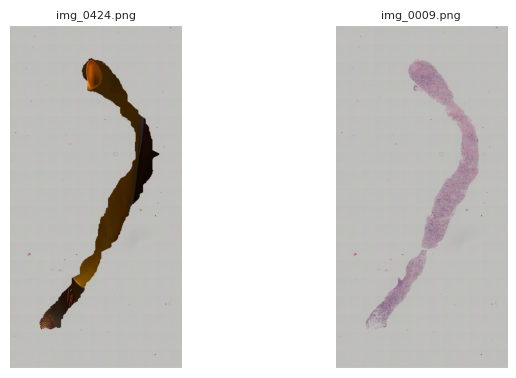

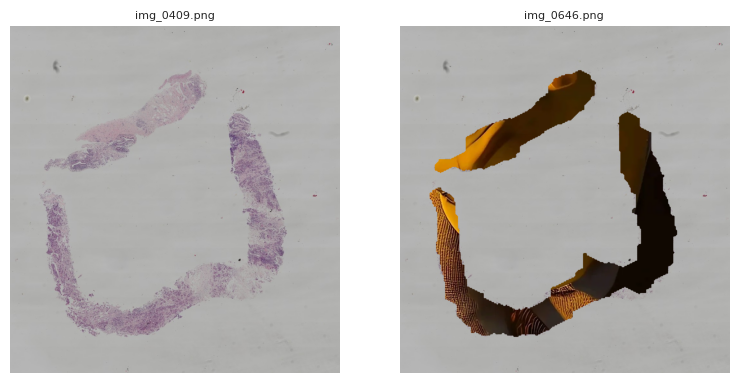

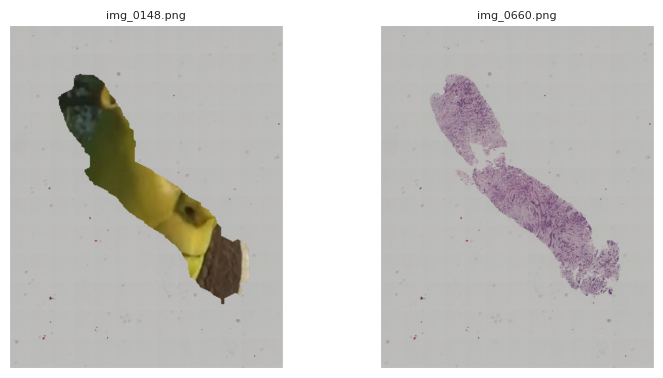

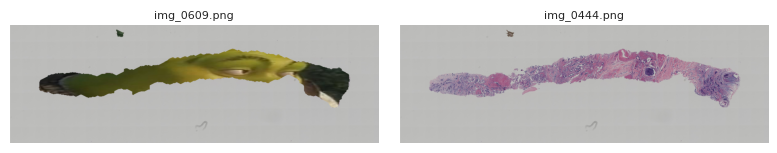

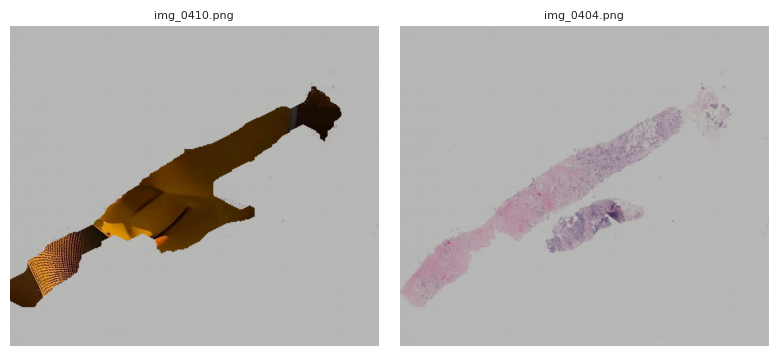

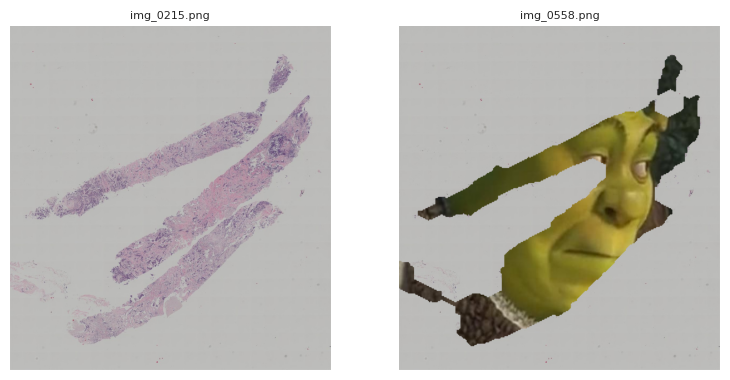

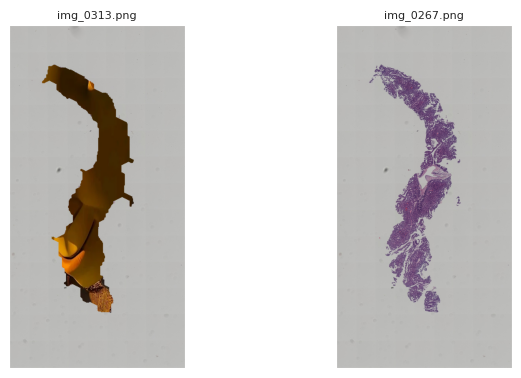

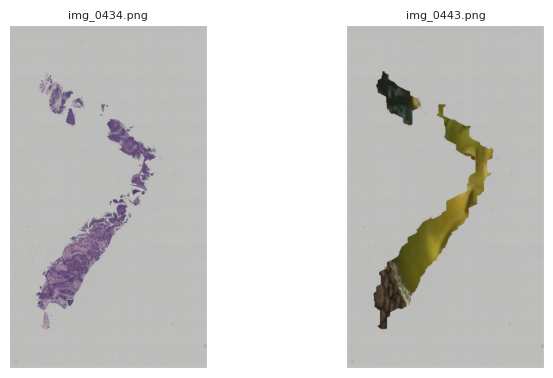

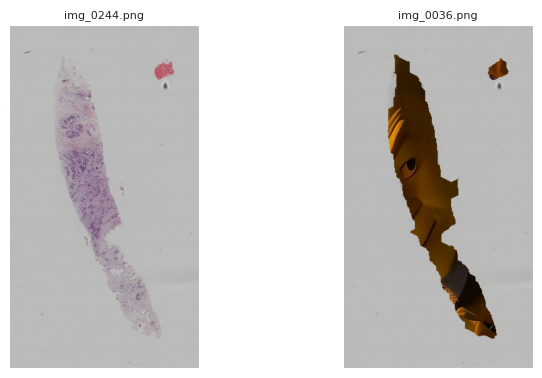

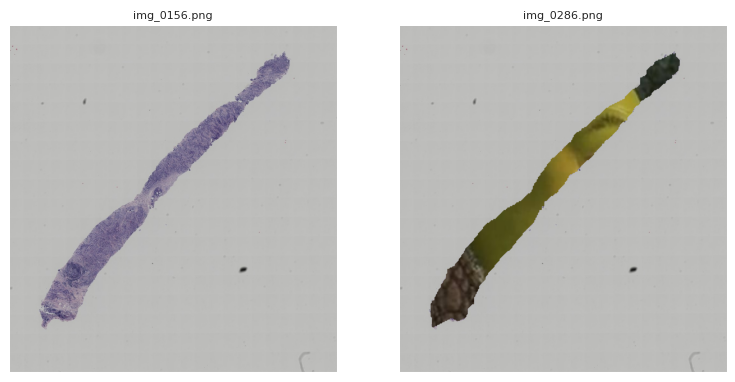

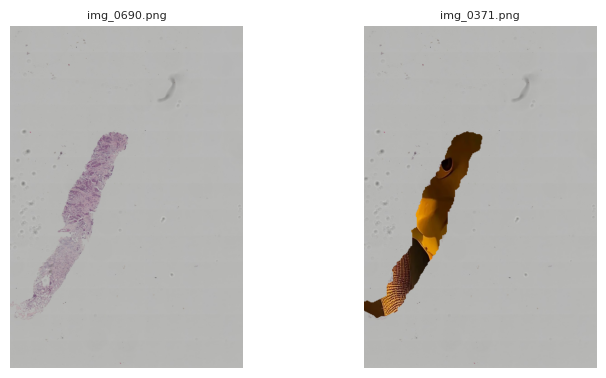

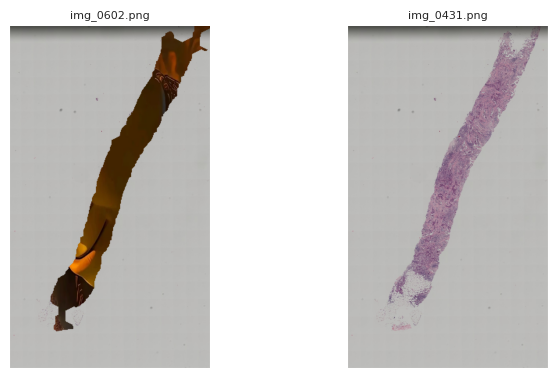

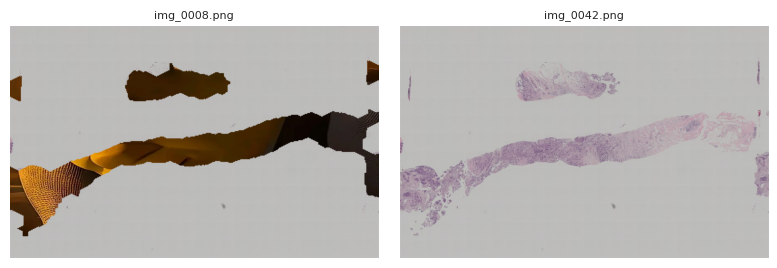

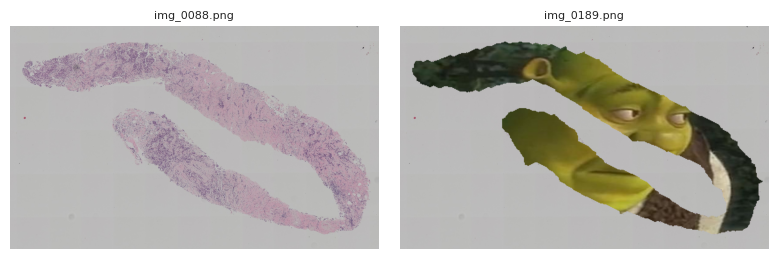

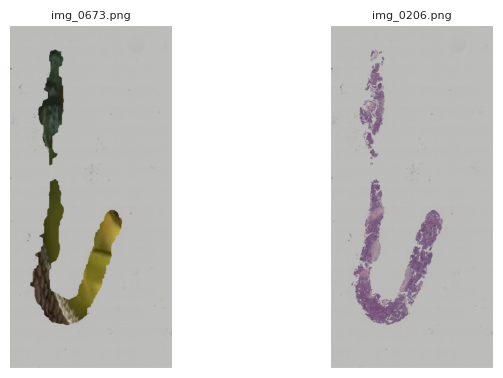

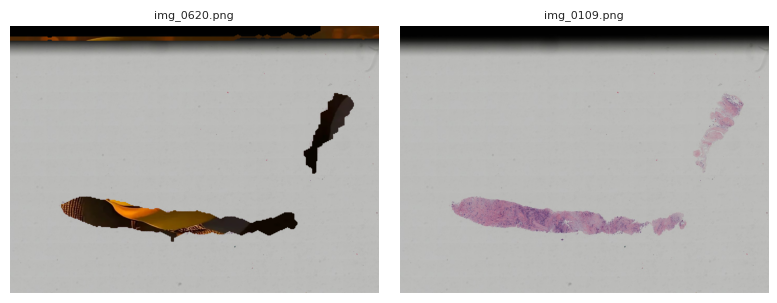

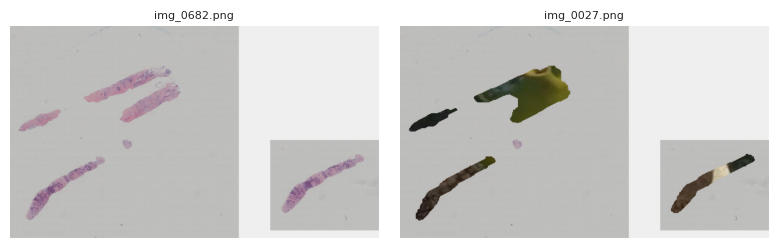

In [37]:
show_duplicates(duplicates_img)